In [2]:
from neuron import h, load_mechanisms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
h.load_file('stdrun.hoc')

1.0

In [4]:
##h.nrn_load_dll("nrnmech.dll")

In [5]:
# Print the names of all density mechanisms
mt = h.MechanismType(0)
mname  = h.ref('')
for i in range(mt.count()):
    mt.select(i)
    mt.selected(mname)
    print(mname[0])

# Print the names of all point processes
mt = h.MechanismType(1)
mname  = h.ref('')
for i in range(mt.count()):
    mt.select(i)
    mt.selected(mname)
    print(mname[0])

morphology
capacitance
pas
extracellular
fastpas
na_ion
k_ion
hh
cl_ion
IClamp
AlphaSynapse
ExpSyn
Exp2Syn
SEClamp
VClamp
OClamp
APCount
NetStim
IntFire1
IntFire2
IntFire4
PointProcessMark
PatternStim
AMPA_Channel
AMPA_Channel_Potentiation
GABA_A_Channel
GenericLigand
GenericReceptor
NMDA_Channel
NMDA_Channel_Calcium


In [6]:
# Create a presynaptic neuron
pre_neuron = h.Section(name='pre')
pre_neuron.L = 20
pre_neuron.diam = 20
pre_neuron.insert('hh')

# Create a soma section
post_neuron = h.Section(name='post')
post_neuron.L = 20     # Length of soma in µm
post_neuron.diam = 20  # Diameter of soma in µm
post_neuron.insert('pas')  # Hodgkin huxley dynamics


# Attach Glutamate Emitter to pre neuron
glutamate = h.GenericLigand(pre_neuron(0.5))
glutamate.decay_rate = 0.1
#glutamate.external_input = 0.01
#glutamate.C_init = 0.1

NMDA_drug = h.GenericLigand(post_neuron(0.5))
NMDA_drug.decay_rate = 0.01
NMDA_drug.C_init = 0.8


# Attach Receptor to soma(0.5)
NMDA_receptor = h.GenericReceptor(post_neuron(0.5))
NMDA_receptor.capacity = 1.0
NMDA_receptor.n_ligands = 2

# Glutamate NMDA binding properties
NMDA_receptor.kd1 = 1.1
NMDA_receptor.efficacy1 = 1
NMDA_receptor.decay1 = 0.01
# Drug NMDA binding properties
NMDA_receptor.kd2 = 5
NMDA_receptor.efficacy2 = -0.5
NMDA_receptor.decay2 = 0.01

# Attach NMDA to soma(0.5)
nmda = h.NMDA_Channel_Calcium(post_neuron(0.5))
nmda.gmax = 0.01
nmda.e = 0
nmda.mg = 1
nmda.taur = 80

# POINTER connection for ligand → receptor
h.setpointer(glutamate._ref_C, 'C_lig1', NMDA_receptor)
h.setpointer(NMDA_drug._ref_C, 'C_lig2', NMDA_receptor)
# POINTER connection for receptor → NMDA
h.setpointer(NMDA_receptor._ref_activation, 'receptor_activation', nmda)


AMPA_receptor = h.GenericReceptor(post_neuron(0.5))
AMPA_receptor.capacity = 1.0
AMPA_receptor.n_ligands = 1

AMPA_receptor.kd1 = .03
#AMPA_receptor.efficacy1 = 0.8
AMPA_receptor.efficacy1 = 0.8
#AMPA_receptor.decay1 = 0.01
AMPA_receptor.decay1 = 10

ampa = h.AMPA_Channel_Potentiation(post_neuron(0.5))
ampa.potentiation_rate = 0.01 # We forgo a little bit of realism of the value here to exaggerate the effect of potentiation
ampa.depression_rate = 0.05
ampa.potentiation_strength = 10 # Ditto here on the realism
ampa.depression_strength = 1
ampa.potentiation_decay = 0.1
ampa.depression_decay = 0.01
ampa.potentiation_threshold = 0.1
ampa.depression_threshold = 0.1
ampa.baseline_gmax = 0.1
ampa.p_ratio = 10
h.setpointer(glutamate._ref_C, 'C_lig1', AMPA_receptor)
h.setpointer(AMPA_receptor._ref_activation, 'receptor_activation', ampa)
h.setpointer(nmda._ref_local_cai, 'local_cai', ampa)


# # Stimulus for ligand release
# stim = h.NetStim()
# stim.start = 10              # Start stimulus at 10 ms
# stim.number = 5              # Fire 5 spikes
# stim.interval = 10           # 10 ms between spikes

# # Connect stimulus to ligand via NetCon (to trigger spikes)
# nc1 = h.NetCon(stim, pre_neuron)
# nc1.weight[0] = 0.2          # Amount of ligand release

nc = h.NetCon(pre_neuron(0.5)._ref_v, glutamate)
nc.threshold = -20
nc.weight[0] = 0.8
nc.delay = 1

iclamp = h.IClamp(pre_neuron(0.5))
iclamp.delay = 5
iclamp.dur = 50
iclamp.amp = 1

iclamp2 = h.IClamp(pre_neuron(0.5))
iclamp2.delay = 100
iclamp2.dur = 50
iclamp2.amp = 1

iclamp3 = h.IClamp(pre_neuron(0.5))
iclamp3.delay = 450
iclamp3.dur = 50
iclamp3.amp = 1

iclamp4 = h.IClamp(pre_neuron(0.5))
iclamp4.delay = 550
iclamp4.dur = 50
iclamp4.amp = 1

iclamp5 = h.IClamp(pre_neuron(0.5))
iclamp5.delay = 850
iclamp5.dur = 50
iclamp5.amp = 1

iclamp6 = h.IClamp(pre_neuron(0.5))
iclamp6.delay = 950
iclamp6.dur = 50
iclamp6.amp = 1

# Record data
t = h.Vector().record(h._ref_t)
v_pre = h.Vector().record(pre_neuron(0.5)._ref_v)
v_post = h.Vector().record(post_neuron(0.5)._ref_v)
glutamate_conc = h.Vector().record(glutamate._ref_C)
drug_conc = h.Vector().record(NMDA_drug._ref_C)
nmda_act = h.Vector().record(NMDA_receptor._ref_activation)
ampa_act = h.Vector().record(AMPA_receptor._ref_activation)
nmda_current = h.Vector().record(nmda._ref_i)
na_current = h.Vector().record(post_neuron(0.5)._ref_ina)
k_current = h.Vector().record(post_neuron(0.5)._ref_ik)
ca_conc = h.Vector().record(nmda._ref_local_cai)  # Calcium concentration
pot_vec = h.Vector().record(ampa._ref_P)
dep_vec = h.Vector().record(ampa._ref_D)

In [7]:
h.tstop = 1200
h.v_init = -65
h.dt = 0.025

In [8]:
h.finitialize(h.v_init)

1.0

In [9]:
h.continuerun(h.tstop)

0.0

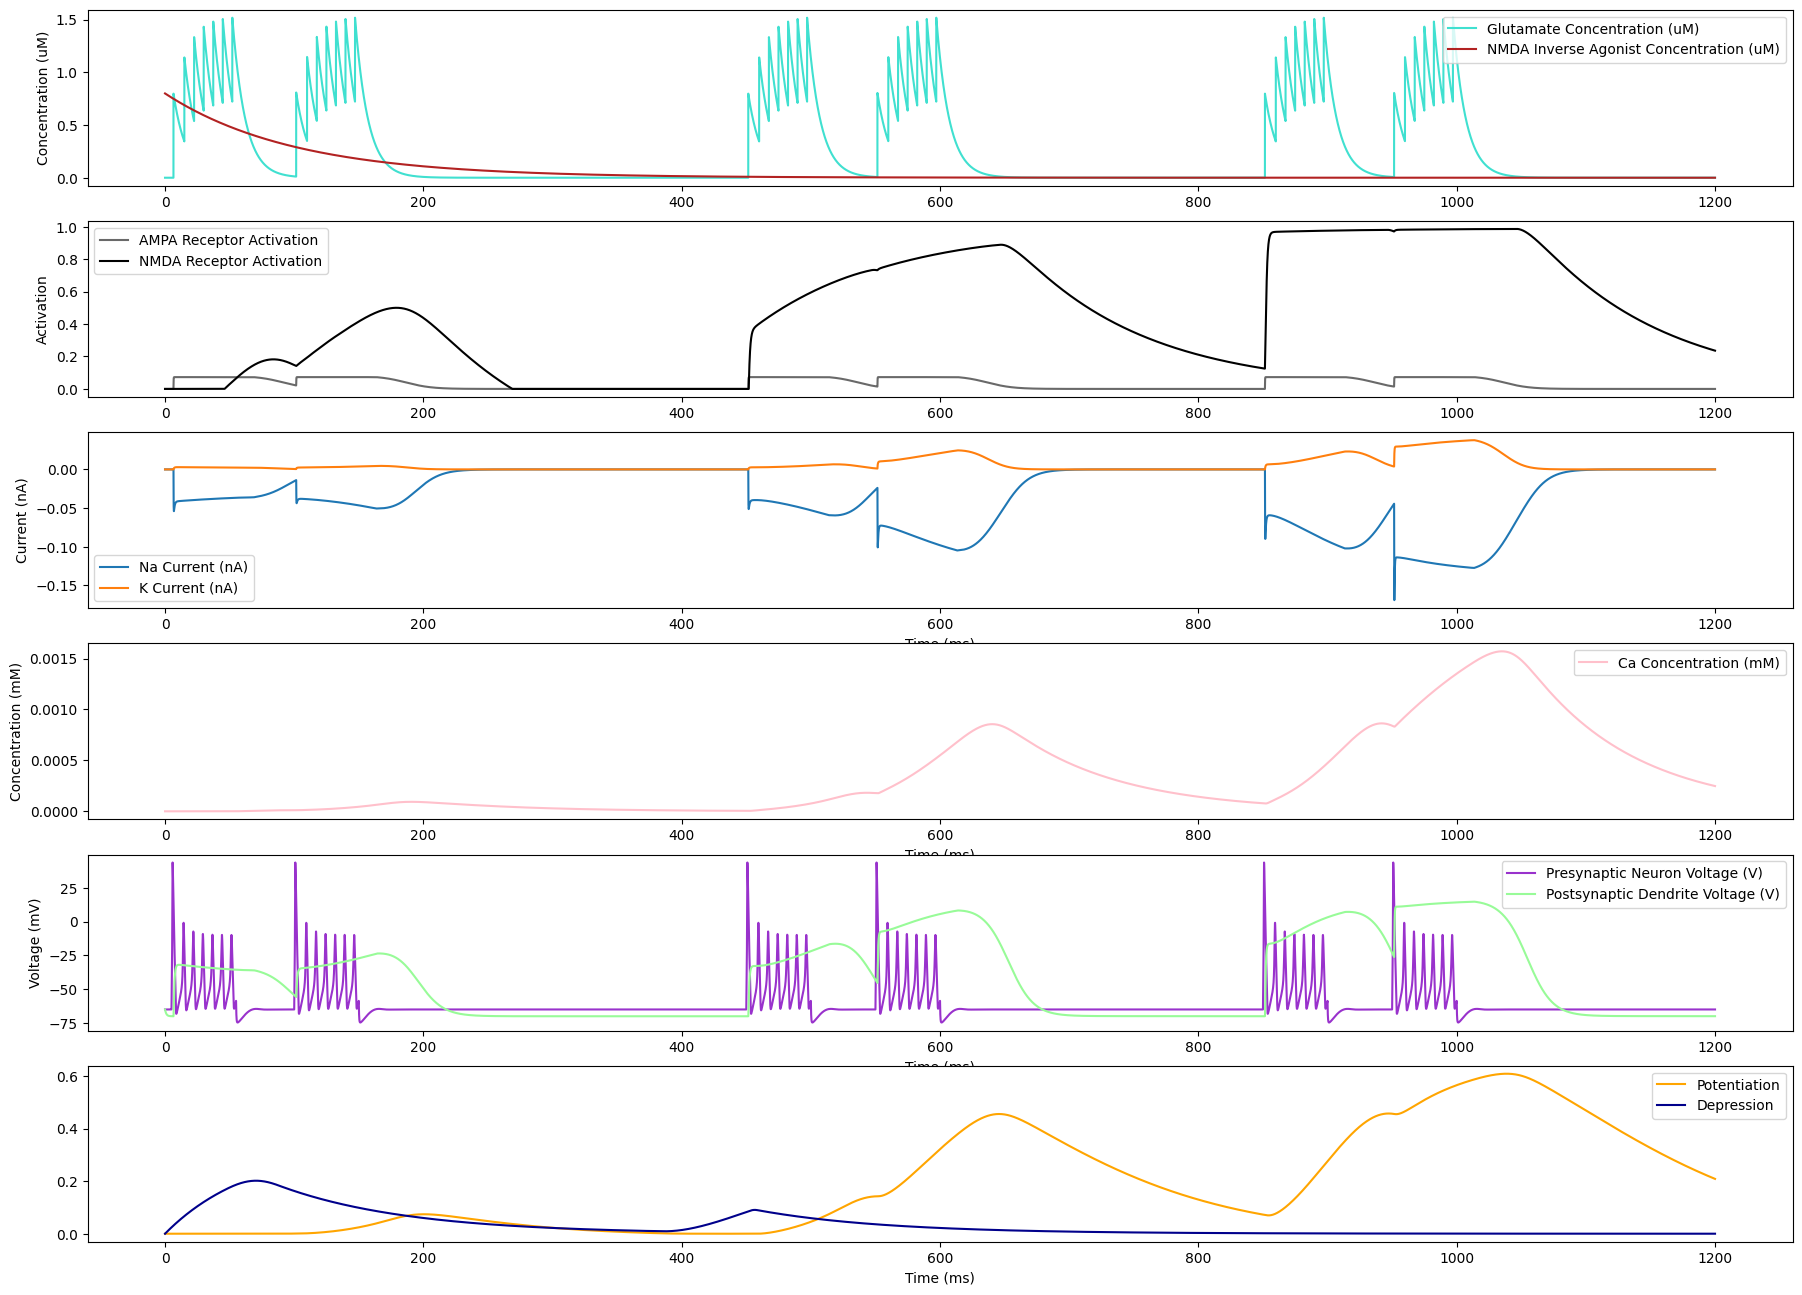

In [10]:
# Plot Results
plt.figure(figsize=(22, 16))

plt.subplot(6, 1, 1)
plt.plot(t, glutamate_conc, label="Glutamate Concentration (uM)", color = "turquoise")
plt.plot(t, drug_conc, label="NMDA Inverse Agonist Concentration (uM)", color="firebrick")
plt.ylabel("Concentration (uM)")
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(t, ampa_act, label="AMPA Receptor Activation", color = "dimgrey")
plt.plot(t, nmda_act, label="NMDA Receptor Activation", color = "black")
plt.ylabel("Activation")
plt.legend()

plt.subplot(6, 1, 3)
#plt.plot(t, nmda_current, label="NMDA Current (nA)")
plt.plot(t, na_current, label="Na Current (nA)")
plt.plot(t, k_current, label="K Current (nA)")
plt.xlabel("Time (ms)")
plt.ylabel("Current (nA)")
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(t, ca_conc, label="Ca Concentration (mM)", color = "pink")
plt.xlabel("Time (ms)")
plt.ylabel("Concentration (mM)")
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(t, v_pre, label="Presynaptic Neuron Voltage (V)", color = "darkorchid")
plt.plot(t, v_post, label="Postsynaptic Dendrite Voltage (V)", color = "palegreen")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(t, pot_vec, label="Potentiation", color = "orange")
plt.plot(t, dep_vec, label="Depression", color = "darkblue")
plt.xlabel("Time (ms)")
plt.legend()

##plt.tight_layout()
plt.show()